# Health insurance analysis

Choosing the right health insurance can be overwhelming with so many options. Here we used unsupervised learning to cluster health insurance plans that are offered to US government employees. We found **insert findings here**. 

The raw dataset is available from the United States Office of Personnel Management [here](https://www.opm.gov/healthcare-insurance/healthcare/plan-information/compare-plans/fehb/PlanDetails?FFSSearch=on&Medicare=False&ZipCode=08550&IncludeNationwide=True&empType=a&payPeriod=c&plans=Z24NJEP1NJEP4NJ&AnnualDeductible=4000&AnnualOutofPocketMaximum=15000&PassThrough=2400&Premiums=1115&MedicalAccount%5BIncludeNo%5D=true&MedicalAccount%5BIncludeYes%5D=true&MedicalAccount%5BIncludeNone%5D=true&PrimaryCareOfficeVisit%5BCopayment%5D=30&PrimaryCareOfficeVisit%5BCoinsurance%5D=30&SpecialistOfficeVisit%5BCopayment%5D=50&SpecialistOfficeVisit%5BCoinsurance%5D=30&DoctorCostInpatientSurgery%5BCopayment%5D=250&DoctorCostInpatientSurgery%5BCoinsurance%5D=30&DoctorCostInpatientSurgery%5BIncludeNone%5D=true&RetailGeneric%5BCopayment%5D=100&RetailGeneric%5BCoinsurance%5D=50&RetailGeneric%5BIncludeNone%5D=true&RetailBrand%5BCopayment%5D=100&RetailBrand%5BCoinsurance%5D=60). We copy/pasted it into a .csv file, and cleaned up the data in this Jupyter Notebook. 

**Disclaimer:** The findings here provide an understanding of how health insurance plans are organized and priced. These findings do not consitute a recommendation, and also do not incorporate key details about the plans, such as the size of provider network, that might be important to one's decision. The health insurance one chooses should be personalized to one's expected health care usage, financial preference and doctor preference. For this we recommend using other resources that offer annual out-of-pocket predictions based on expected health-related events. For example, the ObamaCare website predicts out of pocket expenses based on your anticipated usage. 

## TOC:

* [Load and clean data](#load-data)
* Data Exploration
  * [Deductibles and premiums in HMO vs. PPO](#hmo-ppo)
* Unsupervised Learning
  * Can we recover HMO vs. PPO groups using unsupervised learning?


## Load and clean data <a class = "anchor" id="load-data"></a>

In [2]:
import pandas as pd
import copy
import matplotlib.pyplot as plt


In [3]:
# Load the data: 
df = pd.read_excel('healthcareplans.xlsx')

In [4]:
# Get a sense of data shape: 
df.shape

(380, 13)

In [5]:
# Get a few examples of data: 
# Here, we see that several rows are NaN
df.head(20)

,Plan Name (Plan Code),Plan Type,Enrollment Code,Enrollee Premium,Annual Deductible,Annual Out of Pocket Maximum,Medical Account (HRA/HSA),Primary Care Office Visit,Specialist Office Visit,Doctor Costs Inpatient Surgery,Retail Generic,Retail Brand,Plan Requires Referral to See Certain Specialists
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aetna Advantage Plan - Advantage (Z2),HMO,Z24,53.52,2000,7500,0,0.3,0.3,0.3,Tier 1: $10,Tier 2: 45%,No
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,Z26,117.74,4000,15000,0,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,Z25,141.83,4000,15000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We notice that a lot of the rows are NaN. This is because during the manual copy/paste from website to .csv file, the formatting has not been preserved. 

We'll address this by: 
* Create **df1**, which is a deep copy of our dataframe, **df**. In Python, a deep copy ensures that any changes we make to the new copy does not affect the original. 
* In **df1**, delete any rows where the column **Plan Type** is NaN. This filters out all the 1-person plans. 

In [17]:
df1 = copy.deepcopy(df)

df1 = df[df['Plan Type'].notna()]

# quick check: 
df1.head(15)

,Plan Name (Plan Code),Plan Type,Enrollment Code,Enrollee Premium,Annual Deductible,Annual Out of Pocket Maximum,Medical Account (HRA/HSA),Primary Care Office Visit,Specialist Office Visit,Doctor Costs Inpatient Surgery,Retail Generic,Retail Brand,Plan Requires Referral to See Certain Specialists
1,Aetna Advantage Plan - Advantage (Z2),HMO,Z24,53.52,2000,7500,0,0.3,0.3,0.3,Tier 1: $10,Tier 2: 45%,No
10,Aetna HealthFund CDHP and Aetna Value Plan - C...,HMO,F51,146.95,1000,5000,1000,0.15,0.15,0.15,Tier 1: $10 Tier 3: 50% $300 max,Tier 2: 50% $200 max Tier 3: 50% $300 max,No
20,Aetna HealthFund CDHP and Aetna Value Plan - V...,HMO,F54,142.68,700,6000,0,25,40,0.2,Tier 1: $10 Tier 3: 50% $600 max,Tier 2: 30% $600 max Tier 3: 50% $600 max,No
29,Aetna HealthFund HDHP and Aetna Direct Plan - ...,HMO,N61,70.69,1600,6000,900,0.2,0.2,0.2,Tier 1: $6 Tier 3: 50% $600 Max,Tier 2: 30% $600 Max Tier 3: 50% $600 Max,No
39,Aetna HealthFund HDHP and Aetna Direct Plan - ...,HMO,224,100.60,1800,6900,800,0.15,0.15,0.15,Tier 1: $10 Tier 3: 50% $300 max,Tier 2: 50% $200 max Tier 3: 50% $300 max,No
49,Aetna Open Access - Basic (JN),HMO,JN4,85.97,None,6000,$N/A,25,55,0.2,Tier 1: $10 Tier 3: 50% $300 max,Tier 2: 50% $200 max Tier 3: 50% $300 max,No
58,Aetna Open Access - High (JN),HMO,JN1,289.26,None,5000,$N/A,15,30,You pay nothing,Tier 1: $3 Tier 3: 50% $200 max,Tier 2: $35 Tier 3: 50% $200 max,No
67,Aetna Open Access - Saver (QQ),HMO,QQ4,68.68,1000,6500,$N/A,0.3,0.3,0.3,Tier 1: $10,Tier 2: 50%,No
76,APWU Health Plan - CDHP (47),FFS,474,68.96,1000,6500,1200,0.15,0.15,0.15,$15 min Tier 1: 25% $200 max Tier 2: 25% $200 ...,$15 min Tier 1: 25% $200 max Tier 2: 25% $200 ...,No
86,APWU Health Plan - High (47),FFS,471,99.41,450,6500,0,25,25,0.15,Tier 1: $10 Tier 2: 25% $200 max Tier 3: 45% $...,Tier 1: $10 Tier 2: 25% $200 max Tier 3: 45% $...,No


In [18]:
# Change column names to make them more user-friendly
print(list(df1.columns))

df1 = df1.rename(columns={"Plan Name (Plan Code)": "Name", "Enrollee Premium\xa0": "Premium",
                  "Annual Deductible\xa0": "Deductible", "Annual Out of Pocket Maximum\xa0": "OOP",
                  "Enrollment Code": "Code", "Plan Type": "Type"})

list(df1.columns)

['Plan Name (Plan Code)', 'Plan Type', 'Enrollment Code', 'Enrollee Premium\xa0', 'Annual Deductible\xa0', 'Annual Out of Pocket Maximum\xa0', 'Medical Account (HRA/HSA)', 'Primary Care Office Visit', 'Specialist Office Visit', 'Doctor Costs Inpatient Surgery', 'Retail Generic', 'Retail Brand', 'Plan Requires Referral to See Certain Specialists']


['Name',
 'Type',
 'Code',
 'Premium',
 'Deductible',
 'OOP',
 'Medical Account (HRA/HSA)',
 'Primary Care Office Visit',
 'Specialist Office Visit',
 'Doctor Costs Inpatient Surgery',
 'Retail Generic',
 'Retail Brand',
 'Plan Requires Referral to See Certain Specialists']

## Deductible and premiums in HMO vs. PPO <a class = "anchor" id="hmo-ppo"></a>

Is there a relationship between the deductible vs. premium for a plan? 

In [19]:
# Look at the data types
print(df1.dtypes)

# We notice the 'Premium' column is formatted as a float, which is good. But the 'Deductible' column is formatted as 
# an object, which cannot be plotted numerically. 

Name                                                  object
Type                                                  object
Code                                                  object
Premium                                              float64
Deductible                                            object
OOP                                                   object
Medical Account (HRA/HSA)                             object
Primary Care Office Visit                             object
Specialist Office Visit                               object
Doctor Costs Inpatient Surgery                        object
Retail Generic                                        object
Retail Brand                                          object
Plan Requires Referral to See Certain Specialists     object
dtype: object


In [20]:
# First, replace instances where 'Deductible'=='none' to 0. No deductible means it costs $0: 
df1.loc[(df1['Deductible'] == 'None')] = 0

# Next, turn 'Deductible' column format from object into float:
df1["Deductible"] = df1['Deductible'].astype(float)

print(df1.dtypes)

Name                                                  object
Type                                                  object
Code                                                  object
Premium                                              float64
Deductible                                           float64
OOP                                                    int64
Medical Account (HRA/HSA)                             object
Primary Care Office Visit                             object
Specialist Office Visit                               object
Doctor Costs Inpatient Surgery                        object
Retail Generic                                        object
Retail Brand                                          object
Plan Requires Referral to See Certain Specialists     object
dtype: object


From this plot, it looks like there is no significant correlation between a plan's deductible and its premium. Although, as an over-all trend, as premium increases, the deductible also increases: this is a bit counterintuitive as one might have expected deductibles to decrease as premiums increase. 

correlation coefficient r = 0.3031091264414554
p-value = 0.05405255054491523


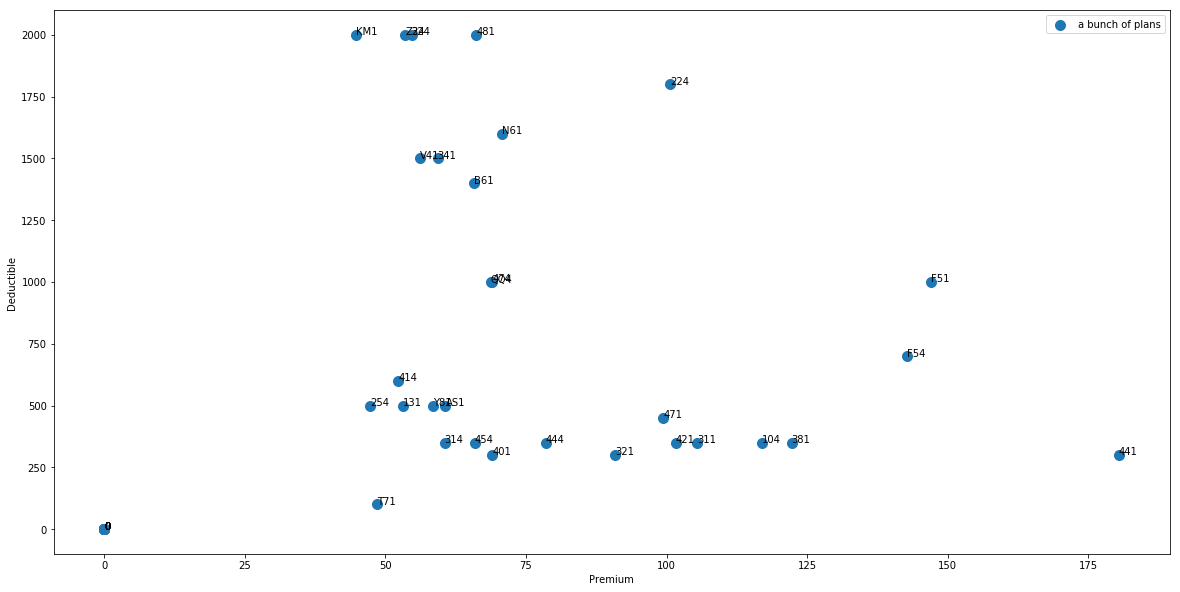

In [22]:
import scipy.stats as sstats
import numpy as np

r, p = sstats.pearsonr(df1['Premium'], df1['Deductible'])
print('correlation coefficient r =', r)
print('p-value =', p)

plt.figure(figsize=(20,10))
plt.scatter(df1['Premium'], df1['Deductible'], marker='o', s=100, label='a bunch of plans');
    
plt.legend()
plt.xlabel('Premium')
plt.ylabel('Deductible')

for i, txt in enumerate(df1['Code']):
    plt.text(df1['Premium'].iloc[i], df1['Deductible'].iloc[i], str(df1['Code'].iloc[i]))
    
plt.show()


However, if we separate the data by HMOs and PPOs, we find that there is a visualizable difference between the way premiums and deductibles are structured for each group. 

For PPOs (labeled FFS), it looks like the deductible is around the same range with the exception of 4 plans. 

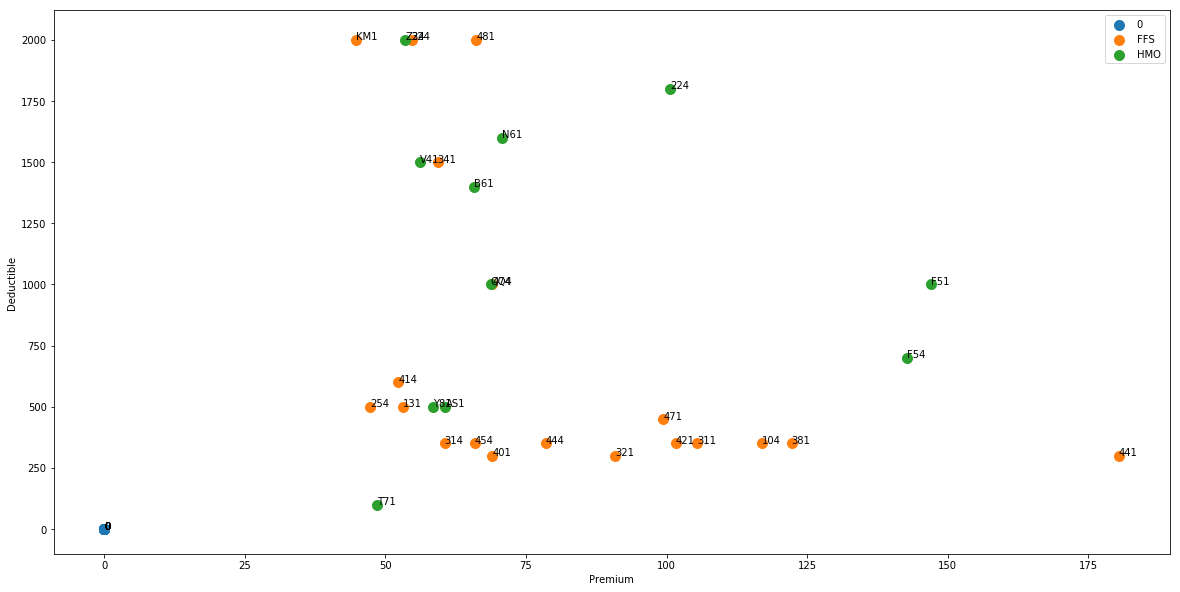

In [114]:
plt.figure(figsize=(20,10))
#plt.scatter(df1['Premium'], df1['Deductible'], marker='o', s=100, label='a bunch of plans');
for key, grp in df1.groupby(['Type']):
    plt.scatter(grp['Premium'], grp['Deductible'], marker='o', s=100, label=key)
    
plt.legend()
plt.xlabel('Premium')
plt.ylabel('Deductible')

for i, txt in enumerate(df1['Code']):
    plt.text(df1['Premium'].iloc[i], df1['Deductible'].iloc[i], str(df1['Code'].iloc[i]))
    
plt.show()


## Can we recover HMO vs. PPO groups using unsupervised learning? 